# ARIMA Forecasting

In [0]:
import pandas as pd

In [0]:
url = "https://raw.githubusercontent.com/hd4niel/Predict-Spotify-Top200/master/data/top_200_features.csv"
spotify = pd.read_csv(url)

In [4]:
spotify.head()

,Unnamed: 0,Artist,Position,Streams,Track Name,acousticness,analysis_url,danceability,date,duration_ms,energy,id_caller,id_other,instrumentalness,key,liveness,loudness,mode,region,speechiness,tempo,time_signature,track_href,type,uri,valence
0,0,Ed Sheeran,1,51095759,Shape of You,0.5810,https://api.spotify.com/v1/audio-analysis/7qiZ...,0.825,2017-01-06--2017-01-13,233713.0,0.652,7qiZfU4dY1lWllzX7mPBI3,7qiZfU4dY1lWllzX7mPBI3,0.000000,1.0,0.0931,-3.183,0.0,global,0.0802,95.977,4.0,https://api.spotify.com/v1/tracks/7qiZfU4dY1lW...,audio_features,spotify:track:7qiZfU4dY1lWllzX7mPBI3,0.9310
1,1,Ed Sheeran,2,35168298,Castle on the Hill,0.0232,https://api.spotify.com/v1/audio-analysis/6PCU...,0.461,2017-01-06--2017-01-13,261154.0,0.834,6PCUP3dWmTjcTtXY02oFdT,6PCUP3dWmTjcTtXY02oFdT,0.000011,2.0,0.1400,-4.868,1.0,global,0.0989,135.007,4.0,https://api.spotify.com/v1/tracks/6PCUP3dWmTjc...,audio_features,spotify:track:6PCUP3dWmTjcTtXY02oFdT,0.4710
2,2,The Weeknd,3,24261229,Starboy,0.1650,https://api.spotify.com/v1/audio-analysis/5aAx...,0.681,2017-01-06--2017-01-13,230453.0,0.594,5aAx2yezTd8zXrkmtKl66Z,5aAx2yezTd8zXrkmtKl66Z,0.000003,7.0,0.1340,-7.028,1.0,global,0.2820,186.054,4.0,https://api.spotify.com/v1/tracks/5aAx2yezTd8z...,audio_features,spotify:track:5aAx2yezTd8zXrkmtKl66Z,0.5350
3,3,Clean Bandit,4,21671209,Rockabye (feat. Sean Paul & Anne-Marie),0.4060,https://api.spotify.com/v1/audio-analysis/5knu...,0.720,2017-01-06--2017-01-13,251088.0,0.763,5knuzwU65gJK7IF5yJsuaW,5knuzwU65gJK7IF5yJsuaW,0.000000,9.0,0.1800,-4.068,0.0,global,0.0523,101.965,4.0,https://api.spotify.com/v1/tracks/5knuzwU65gJK...,audio_features,spotify:track:5knuzwU65gJK7IF5yJsuaW,0.7420
4,4,ZAYN,5,21513043,I Don’t Wanna Live Forever (Fifty Shades Darke...,0.0631,https://api.spotify.com/v1/audio-analysis/3NdD...,0.735,2017-01-06--2017-01-13,245200.0,0.451,3NdDpSvN911VPGivFlV5d0,3NdDpSvN911VPGivFlV5d0,0.000013,0.0,0.3250,-8.374,1.0,global,0.0585,117.973,4.0,https://api.spotify.com/v1/tracks/3NdDpSvN911V...,audio_features,spotify:track:3NdDpSvN911VPGivFlV5d0,0.0862


In [5]:
spotify.columns

Index(['Unnamed: 0', 'Artist', 'Position', 'Streams', 'Track Name',
       'acousticness', 'analysis_url', 'danceability', 'date', 'duration_ms',
       'energy', 'id_caller', 'id_other', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'region', 'speechiness', 'tempo',
       'time_signature', 'track_href', 'type', 'uri', 'valence'],
      dtype='object')

## Drop the missing features

In [0]:
s = spotify["danceability"].isna()
indices = s[s == True].index.values.tolist()
spotify = spotify.drop(index=indices)
spotify = spotify.reset_index()

## Extract numerical features

In [0]:
features = spotify.select_dtypes(include=["float64"])

## Extract the date of every top 200 list

In [0]:
dates = []
for i in range(0, spotify.shape[0], 200):
    dates.append(spotify["date"][i][:10])

In [0]:
feature_mean = pd.DataFrame(columns=features.columns, index=pd.to_datetime(dates))
for feature in features.columns:
    average = []
    for i in range(0, spotify.shape[0], 200):
        average.append(spotify[feature][i:i+200].mean())
    feature_mean[feature] = average

In [0]:
feature_mean = feature_mean.asfreq(freq="W", method='bfill')

In [11]:
feature_mean.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
2017-01-08,0.188506,0.678070,222369.595,0.659144,0.011800,5.075,0.159478,-6.011535,0.585,0.118482,121.007170,4.010,0.489789
2017-01-15,0.201954,0.674755,223224.455,0.648524,0.009049,5.050,0.160663,-6.093700,0.600,0.117990,120.890135,4.010,0.481608
2017-01-22,0.194442,0.681720,223771.285,0.651434,0.007873,5.015,0.162028,-6.021405,0.600,0.119633,120.809115,4.010,0.485549
2017-01-29,0.207496,0.676025,224696.305,0.652214,0.007852,5.050,0.164080,-6.073245,0.595,0.123012,120.042640,4.015,0.482391
2017-02-05,0.207728,0.668920,224586.910,0.655065,0.007979,4.995,0.158538,-5.951895,0.610,0.117958,121.082985,4.010,0.479712


## Manual ARIMA

In [12]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
timeseries = feature_mean["acousticness"]

In [14]:
print("p-value:", adfuller(timeseries.dropna())[1])

p-value: 0.43453119367672177


When we check Augmented Dickey Fuller (ADF) test, the time series is stationary.

### Find a "d" value using autocorrelation.

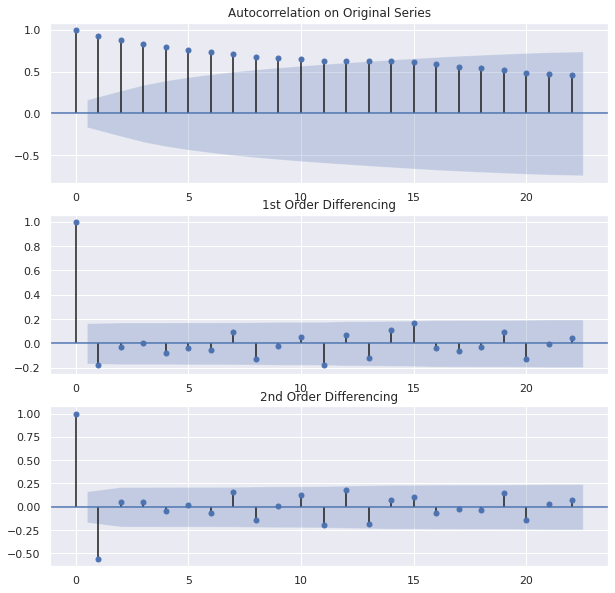

In [15]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(311)
fig = plot_acf(timeseries, ax=ax1, title="Autocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig = plot_acf(timeseries.diff().dropna(), ax=ax2, title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(timeseries.diff().diff().dropna(), ax=ax3, title="2nd Order Differencing")

The timeseries is stationary at d = 1.

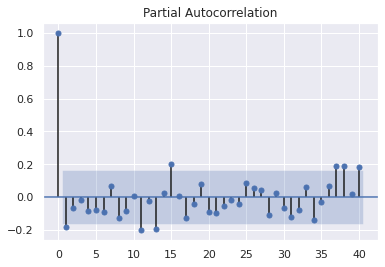

In [16]:
plot_pacf(timeseries.diff().dropna(), lags=40) #knowing d=1 we apply diff() once
plt.show()

Lag 1 is above the significance level and so p = 1.

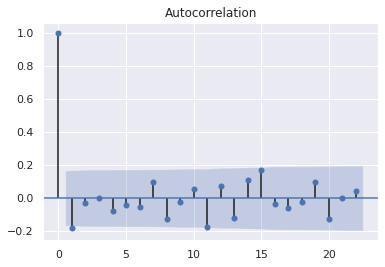

In [17]:
plot_acf(timeseries.diff().dropna())
plt.show()

Lag 1 is above the significance level and so q = 1.

### Our model

In [18]:
model = ARIMA(timeseries, order=(1, 1, 1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.acousticness   No. Observations:                  139
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 407.424
Method:                       css-mle   S.D. of innovations              0.013
Date:                Tue, 02 Jun 2020   AIC                           -806.848
Time:                        00:03:05   BIC                           -795.110
Sample:                    01-15-2017   HQIC                          -802.078
                         - 09-08-2019                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0005      0.000      1.407      0.162      -0.000       0.001
ar.L1.D.acousticness     0.7630      0.141      5.427      0.000       0.487       1.039
ma.L1.D.acousticness    -0.9335      0.094     -9.967      0.000      -1.117      -0.750
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3106           +0.0000j            1.3106            0.0000
MA.1            1.0712           +0.0000j            1.0712            0.0000
-----------------------------------------------------------------------------
"""

The less AIC is, the better model is.

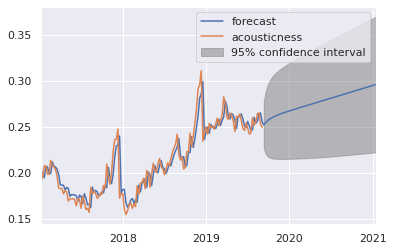

In [19]:
graph = results.plot_predict(1, 210)
plt.show()

## Auto ARIMA

In [21]:
!pip install pmdarima
import pmdarima as pm

     |████████████████████████████████| 1.5MB 2.7MB/s 
     |████████████████████████████████| 2.1MB 13.1MB/s 
     |████████████████████████████████| 8.7MB 27.5MB/s 
  Found existing installation: Cython 0.29.18
    Uninstalling Cython-0.29.18:
      Successfully uninstalled Cython-0.29.18
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


ImportError: ignored

In [0]:
def arimamodel(timeseries):
    automodel = pm.auto_arima(timeseries, 
                              start_p=1, 
                              start_q=1,
                              test="adf",
                              seasonal=False,
                              trace=True)
    return automodel

In [0]:
def plotarima(n_periods, timeseries, automodel):
    # Forecast
    fc, confint = automodel.predict(n_periods=n_periods, return_conf_int=True)
    # Weekly index
    fc_ind = pd.date_range(timeseries.index[timeseries.shape[0]-1], periods=n_periods, freq="W")
    # Forecast series
    fc_series = pd.Series(fc, index=fc_ind)
    # Upper and lower confidence bounds
    lower_series = pd.Series(confint[:, 0], index=fc_ind)
    upper_series = pd.Series(confint[:, 1], index=fc_ind)
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(timeseries)
    plt.plot(fc_series, color="red")
    plt.xlabel("date")
    plt.ylabel(timeseries.name)
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color="k", alpha=.25)
    plt.legend(("past", "forecast", "95% confidence interval"), loc="upper left")
    plt.show()